# Model checking

##### Keywords: model checking, posterior predictive, test statistic, discrepancy, bayesian p-values

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

We'll illustrate some of the concepts of Model Checking by considering an experiment.

## The light speed experiment

Simon Newcomb did an experiment in 1882 to measure the speed of light. These are the times required for light to travel 7442 metres. These are recorded as deviations from 24,800 nanoseconds.

In [2]:
light_speed = np.array([28, 26, 33, 24, 34, -44, 27, 16, 40, -2, 29, 22, 24, 21, 25,
                        30, 23, 29, 31, 19, 24, 20, 36, 32, 36, 28, 25, 21, 28, 29,
                        37, 25, 28, 26, 30, 32, 36, 26, 30, 22, 36, 23, 27, 27, 28,
                        27, 31, 27, 26, 33, 26, 32, 32, 24, 39, 28, 24, 25, 32, 25,
                        29, 27, 28, 29, 16, 23])

In [3]:
light_speed.std()

10.663610099255504

We use a normal models with reakly informative priors to model this experiment.

In [4]:
with pm.Model() as light_model:
    mu = pm.Uniform('mu', lower=-1000,
                    upper=1000.0)
    sigma = pm.Uniform('sigma', lower=0.1, upper=1000.0)
    obsv = pm.Normal('obsv', mu=mu, sd=sigma, observed=light_speed)

And let us sample....

In [5]:
with light_model:
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, mu_interval__]
100%|██████████| 10500/10500 [00:08<00:00, 1191.06it/s]
The acceptance probability does not match the target. It is 0.881671068051, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.888306785997, but should be close to 0.8. Try to increase the number of tuning steps.


In [6]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,26.206077,1.346849,0.009393,23.571715,28.84782,18789.0,1.000004
sigma,10.950253,0.969146,0.006581,9.158164,12.90844,19058.0,1.000050


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ad76518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11ac43908>]], dtype=object)

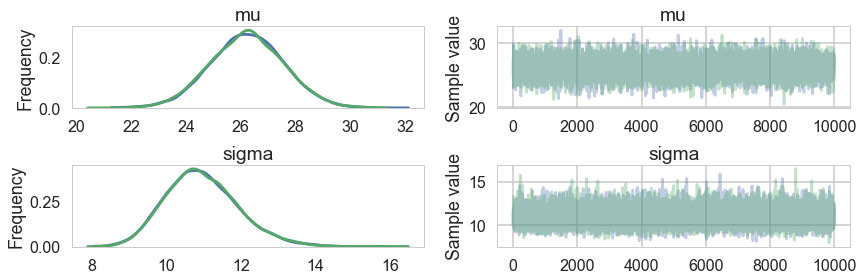

In [7]:
pm.traceplot(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11afaf828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11b31fe10>]], dtype=object)

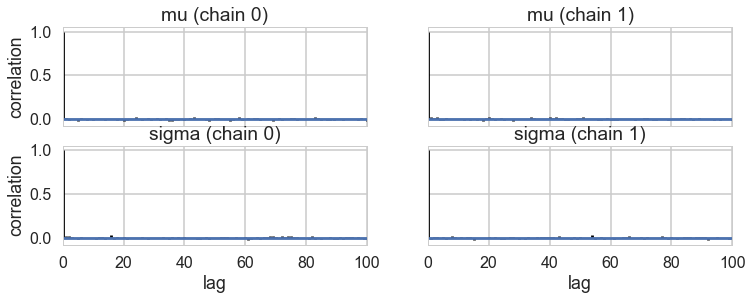

In [8]:
pm.autocorrplot(trace)

Ok, so we have a reasonable model from the traces. But is it well specified? Does it describe our data well? Do do this, we go back to our old friend the posterior predictive distribution, which we now utilize in multiple ways.

## Multiple replications of the posterior predictive

Let us engage in tamping down our notation a bit. We Usually write, for the posterior predictive distribution,

$$p(\{y^\*\}) = \int p(\{y^\*\} \vert \theta) p(\theta \vert \cal{D}) d\theta$$

To avoid confusion with observed data $\cal{D} = \{y\}$, we define $\{y_{r}\}$ as the replicated data, the data we would see tomorrow if the experiment that produced $\{y\}$ today were replicated with the same model and same value of $\theta$ that produced todays data. Since of course we only have a posterior inference for $\theta$, one can think of $y_r$ as simply coming from the posterior predictive, with the caveat that if there are covariates $\{x^{\*}\}$, then $\{y_r\}$ is calculated at those covariates only: in other words we are repredicting at the covariates which gave us the current data.

Our usual way to sample from the posterior predictive has been to draw one $y$ for each $\theta$. In this way we are sampling from the joint $(y_r, \theta )$ distribution. To get us the posterior predictive distribution we have ignored the $\theta$ samples so as to marginalize and carry out the above integral.

But this is a place where we will diverge from this prescription. We'll, so-to-speak, sample an entire $\{y_r\}$ at each $\theta$. The idea behind this is that the size of $\{y_r\}$ is the size of the dataset, in this case, 66. 66 samples are probably ok for simple expectations, but too less to characterize the posterior predictive. So we'll pick $M$ samples from our trace of $\theta$, with replacement (perhaps even the whole trace), and get dataset-size (66) samplea for EACH $\theta$.

## Informally using a test-statistic

We might wish to compute a test statistic from the posterior predictive. Say for example, we wish to talk about the minimum value of the posterior predictive.

The way to do this is to replicate the posterior predictive multiple times. We show that below:

In [51]:
ja = pm.sample_ppc(trace, samples=1000, model=light_model)
ja['obsv'].flatten().shape

100%|██████████| 1000/1000 [00:00<00:00, 2620.39it/s]


(1000,)

In [52]:
samps = np.zeros((66, 1000))
for i in range(66):
    if i%10 == 0:
        print(i)
    temp = pm.sample_ppc(trace, samples=1000, model=light_model, progressbar=False)
    samps[i,:] = temp['obsv'].flatten()


0
10
20
30
40
50
60


In [53]:
samps.shape

(66, 1000)

We can kde the dataset against the kde of the posterior predictives

Lets see the minimum value on our actual data

In [13]:
light_speed.min()

-44

In [56]:
samps.min(axis=0).shape

(1000,)

And let us then plot the minimum values from our arrays on a histogram against the actual value.

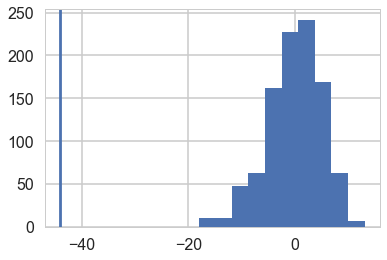

In [57]:
plt.hist(samps.min(axis=0));
plt.axvline(light_speed.min())

Wow, the real dataset is quite an outlier, leading us to conclude that for minima, at-least, our model is totally mis-specified, we should have probably chosen a distribution with fatter tails.

We can informally ask: in what fraction of our simulations did the light-speed minimum exceed the minimum of the data. Here the answer is all.

In [59]:
np.mean(samps.min(axis=0) > light_speed.min())

1.0

## Visual inspection of posterior predictives

We can visually inspect our posterior predictives:

In [60]:
sampssmall=samps[:, np.random.choice(range(1000), size=20, replace=True)]
sampssmall.shape

(66, 20)

In [62]:
sampssmall[:,0]

array([ 37.6802972 ,  22.31299636,  39.16253202,  43.25152691,
        20.76254594,  38.22581542,  18.44720786,  23.15562763,
        44.38917284,  28.97797684,  30.46288311,  12.05989098,
        27.21649293,  18.22662598,  14.5403759 ,  23.17814384,
         9.92038184,  25.4108982 ,  39.60363576,  31.91840716,
        17.03471901,  27.70200087,  16.07994995,  34.48808195,
        15.17375972,  40.12504842,  32.07898314,   9.36790312,
        22.07764229,   2.86027405,  33.27882549,  32.16458644,
        33.10121071,  28.78839458,  34.27338805,  14.24132464,
        16.3129266 ,  17.04092026,  26.4489131 ,  30.44223787,
        24.69083941,  42.06834578,   6.20778662,  16.70614666,
        31.0481992 ,  22.40348868,  36.13231221,  41.48931877,
        22.4192824 ,  29.09050359,  26.12503031,   8.0536481 ,
        45.7630253 ,  49.3982478 ,  28.12268516,  35.17145912,
        31.07608769,  13.74024241,  30.88395389,  21.75186392,
        16.92229432,  25.38598798,   2.48906575,  62.46

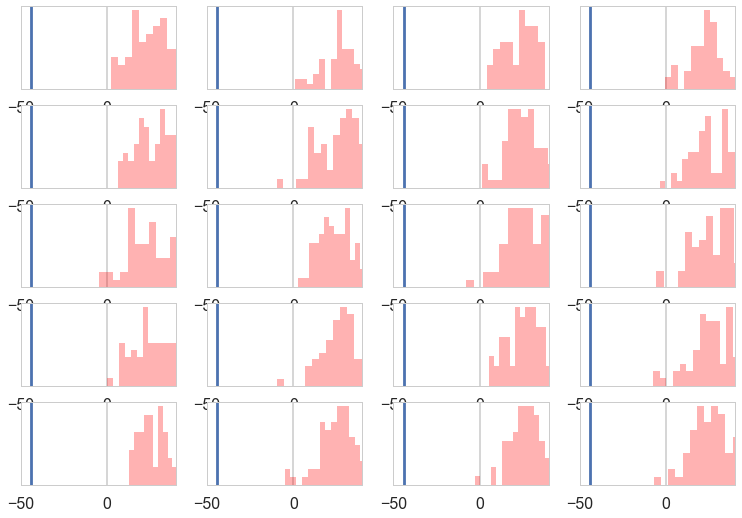

In [64]:
with sns.plotting_context('poster'):
    fig, axes = plt.subplots(nrows=5, ncols=4)

    for ax, s in zip(axes.ravel(), range(20)):
        sdata = sampssmall[:,s]
        ax.hist(sdata, bins=15, histtype='stepfilled', color='r', alpha=.3, ec='none')
        ax.set_yticks([]);
        ax.set_xlim([-50, 40])
        ax.axvline(light_speed.min())
        #ax.set_xticks([]);

And compare their shape against our actual distribution:

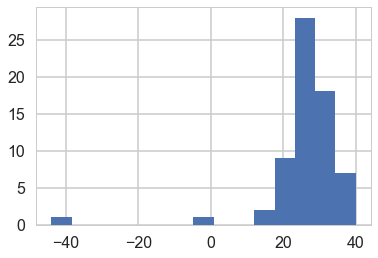

In [23]:
plt.hist(light_speed, bins=15);

All the posterior predictive histograms look different from the above histogram of actual data. This definitely looks like a mis-specified model.

## Discrepancy p-values

As Gelman says:

>A test quantity, or discrepancy measure, T(\{y\},θ), is a scalar
summary of parameters and data that is used as a standard when comparing data to
predictive simulations. Test quantities play the role in Bayesian model checking that test
statistics play in classical testing. We use the notation T(\{y\}) for a test statistic, which is a
test quantity that depends only on data; in the Bayesian context, we can generalize test
statistics to allow dependence on the model parameters under their posterior distribution.
This can be useful in directly summarizing discrepancies between model and data. 

### Classical p-values. 

The classical p-value for the test statistic $T(\{y\})$ is given by

$$p_C = P(T(\{y_r\}) \ge T(\{y\}) \vert \theta)$$

 where the probability is taken over the distribution of $\{y_r\}$ with $\theta$ fixed. In other words, we perform the bootstrap and calculate the value of the test statistic in each replicate. Then we see in what fraction of the replicates is the test-statistic greater than that from the data set. 
 
Remember that in frequentist statistics the point value of $\theta$ is fixed.

### Posterior predictive p-values. 

We are bayesians now, so we dont just deal in point estimates, As with everything else, we simply compute averages.

But these averages are slightly different. Upto now we have been computing averages over the posterior distribution. Now our average will be over the joint distribution of the replicant posterior predictive and posterior.

Quoting Gelman:
>The Bayesian p-value is defined as the probability that the replicated data could be more extreme than the observed data, as measured by the test quantity:

$$p_B = Pr(T(\{y_{r}\},\theta) \ge T(\{y\},\theta) \vert \{y\}),$$

>where the probability is taken over the posterior distribution of $\theta$ and the posterior predictive
distribution of $\{y_r\}$ (that is, the joint distribution, $p(\theta,\{y_r\} \vert \{y\}))$. Thus:

$$p_B = \int d\theta\,d\{y_r\} \, I(T(\{y_{r}\},\theta) \ge T(\{y\},\theta)) \, p(\{y_r\} \vert \theta) p(\theta \vert \{y\})$$

>where I is the indicator function. In this formula, we have used the property of the predictive distribution that $p(\{y_r\} \vert \theta, \{y\}) = p(\{y_r\} \vert \theta)$.

Well, these integrals may seem complex, but sampling comes to our rescue. We know how to sample from posteriors and posterior predictives, and our technique indeed directly gives us their joint which we then "maginalize-by-ignoring". So we just draw our samples as always, and using the usual Monte-Carlo idea, its the fraction of the samples where the indicator function is 1 that gives us our p-value.

The p-values correspond to tail-probability, the probabulity that the statistic is more extreme in the posterior predictive distribution than in the data. If the value of this statistic, also called the discrepancy is close to (0) 1, then you are saying that the posterior-predictive is always (less) more extreme. This is what happened with the minima. you could think of the "data-arrived" statistic as a sort of null value, with calues close to 0 or 1 as some sort of rejection criterion. But dont just go all nonsensical at 0.05 :-)

Gelman:
>A model is suspect if a discrepancy is of practical importance and its observed value has a tail-area probability near 0 or 1, indicating that the observed pattern would be unlikely to be seen in replications of the data if the model were true. An extreme p-value implies that the model cannot be expected to capture this aspect of the data. A p-value is a posterior prob- ability and can therefore be interpreted directly—although not as Pr(model is true  \vert  data). Major failures of the model, typically corresponding to extreme tail-area probabilities (less than 0.01 or more than 0.99), can be addressed by expanding the model appropriately. Lesser failures might also suggest model improvements or might be ignored in the short term if the failure appears not to affect the main inferences. In some cases, even extreme p-values may be ignored if the misfit of the model is substantively small compared to varia- tion within the model.

>Finding an extreme p-value and thus ‘rejecting’ a model is never the end of an analysis; the departures of the test quantity in question from its posterior predictive distribution will often suggest improvements of the model or places to check the data, as in the speed of light example. Moreover, even when the current model seems appropriate for drawing inferences (in that no unusual deviations between the model and the data are found), the next scientific step will often be a more rigorous experiment incorporating additional factors, thereby providing better data. 

### Simulated Sample Variance

As Gelman says:

>The sample variance does not make a good test statistic because it is a sufficient statistic of the model and thus, in the absence of an informative prior distribution, the posterior distribution will automatically be centered near the observed value. We are not at all surprised to find an estimated p-value close to 1/2 .

Here is one way to carry this out, by hand.

In [24]:
indices=np.random.choice(range(len(trace)), size=200, replace=True)

In [25]:
mus = trace['mu'][indices]
sigmas = trace['sigma'][indices]

In [26]:
ppc2=np.empty((66,200))
for i in range(66):
    ppc2[i,:] = np.random.normal(loc=mus, scale=sigmas)

In [27]:
ppc2.shape

(66, 200)

In [28]:
ppvars2=np.var(ppc2, ddof=1, axis=0)
ppvars2.shape

(200,)

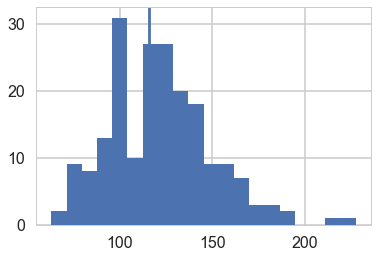

In [29]:
plt.hist(ppvars2, bins=20);
plt.axvline(np.var(light_speed, ddof=1));

In [30]:
np.mean(ppvars2>=np.var(light_speed, ddof=1))

0.59499999999999997

### A measure of symmetry

We can construct an outlier-resistant model-adequacy check by seeing if the model is adequate but for extreme tails. Here is a test quantity sensitive to asymmetry in the center of the distribution:

$$T(\{y\},\theta)= \vert y(61) − \theta \vert − \vert y(6) − \theta \vert.$$

For a 66 point dataset this roughly reflects the middle 80% of the mass. It should be distributed about 0 if the predictive is symmetric

In [31]:
tee_ppc=[]
tee_data=[]
data_sort=np.sort(light_speed)
for i in range(200):
    sortarray = np.sort(ppc2[:,i])
    tee_data.append(np.abs(data_sort[60] - mus[i]) - np.abs(data_sort[5] - mus[i]))
    tee_ppc.append(np.abs(sortarray[60] - mus[i]) - np.abs(sortarray[5] - mus[i]))

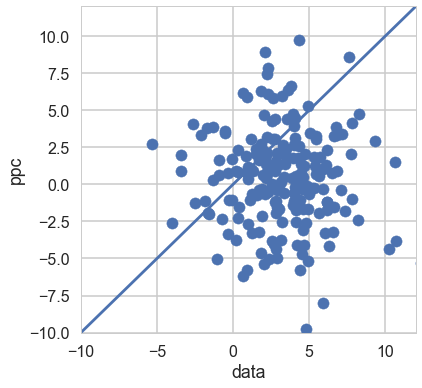

In [32]:
plt.figure(figsize=(6,6))
plt.scatter(tee_data, tee_ppc);
plt.plot([-10, 12],[-10,12]);
plt.xlim([-10,12])
plt.ylim([-10,12])
plt.xlabel("data")
plt.ylabel("ppc")

In [33]:
np.mean(np.array(tee_ppc) >= np.array(tee_data))

0.26000000000000001

Thus any asymmetry can be simply explained by sampling variation.

In this way, this model is adequate for some purposes but not for others.